# **Capstone 2 – Fraud Detection: Modeling Notebook**

This notebook follows the modeling pipeline:

**Steps:**
1. Imports & Setup
2. Load preprocessed data
3. Train-test split
4. Feature scaling
5. Handle class imbalance (SMOTE)
6. Train models: Logistic Regression, Random Forest, XGBoost
7. Evaluate models: classification report, confusion matrix, ROC & PR curves
8. Feature importance
9. Final model selection


# 1. Imports and Setup

In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


# 2. Load Preprocessed Dataset

We use the cleaned CSV from the preprocessing notebook.


In [4]:
df = pd.read_csv("creditcard_sample.csv")
df = df.drop(columns=["Time"])  # Drop Time feature
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.212868,0.314473,0.280272,0.642528,-0.173938,-0.599932,0.017676,-0.072350,0.009880,-0.330543,...,-0.258437,-0.705438,0.157189,0.037345,0.147432,0.123681,-0.005811,0.027712,1.98,0
1,-0.042815,1.176697,0.043358,0.604963,0.091294,-0.161744,-0.890933,-2.588433,0.595272,-1.576134,...,-1.447158,0.011065,0.029984,0.006999,0.413975,0.319339,0.039097,0.259612,0.76,0
2,0.270160,0.792771,-0.277856,-0.095859,1.073333,-0.440614,1.029284,-0.374799,1.611696,-1.524294,...,-0.157880,0.112374,-0.130635,0.455802,-0.148961,0.474769,-0.204900,-0.200123,39.99,0
3,1.252733,0.293642,0.053431,0.516684,0.076941,-0.295868,-0.004559,-0.029834,0.067626,-0.325220,...,-0.296023,-0.815108,0.093337,-0.504924,0.214941,0.157597,-0.007207,0.021775,0.89,0
4,-0.089956,1.251482,0.044823,2.015908,0.537991,1.714838,-1.049764,-2.037580,-0.536713,1.266543,...,2.541931,0.043431,0.359707,-1.365907,-0.790213,0.074159,0.012837,-0.134409,10.59,0


# 3. Train-Test Split

We split **before scaling and SMOTE** to prevent data leakage.


In [6]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (20246, 29)
Test shape: (8678, 29)


# 4. Scale the Amount Feature

We scale `Amount` only; PCA features are already scaled.


In [8]:
scaler = StandardScaler()

X_train["Amount"] = scaler.fit_transform(X_train[["Amount"]])
X_test["Amount"] = scaler.transform(X_test[["Amount"]])


# 5. Handle Class Imbalance (SMOTE)

Oversample fraud cases **only in the training set**.


Original class distribution:
 Class
0    19902
1      344
Name: count, dtype: int64

After SMOTE:
 Class
0    19902
1    19902
Name: count, dtype: int64


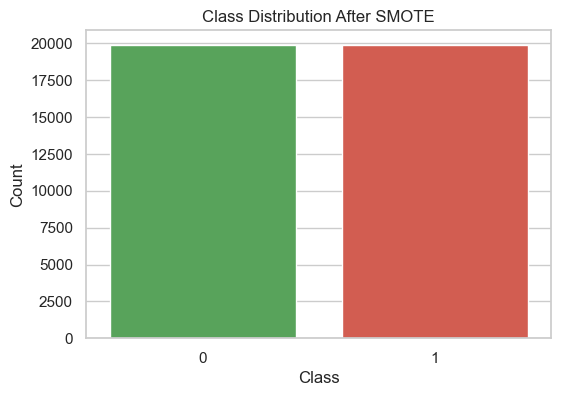

In [10]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_res.value_counts())

# Optional: visualize
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res, hue=y_train_res, palette=['#4CAF50','#E74C3C'], legend=False)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()



Fraud is rare (~0.172% of transactions). SMOTE generates synthetic fraud samples to give the model enough examples to learn from. The bar chart shows that the resampled dataset has equal numbers of fraud and non-fraud samples.

# 6. Train Models

We train three models:
- Logistic Regression
- Random Forest
- XGBoost


XGBoost model created successfully.
=== Evaluating XGBoost ===

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       0.88      0.85      0.87       148

    accuracy                           1.00      8678
   macro avg       0.94      0.92      0.93      8678
weighted avg       1.00      1.00      1.00      8678



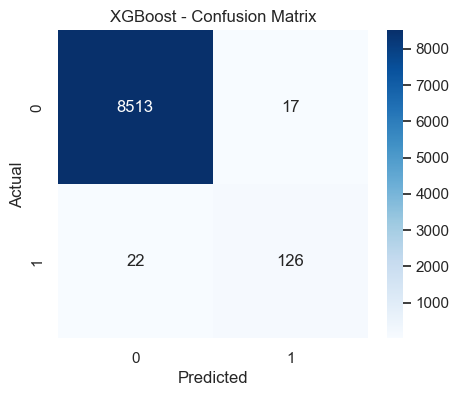

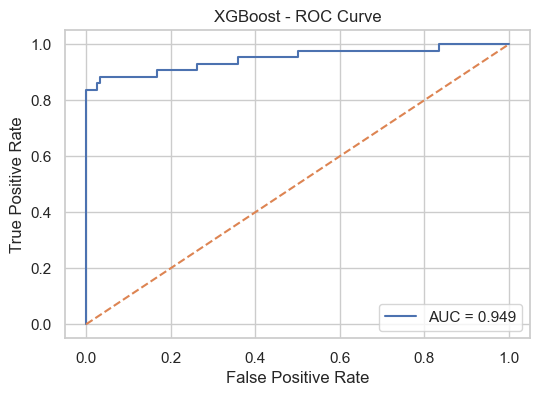

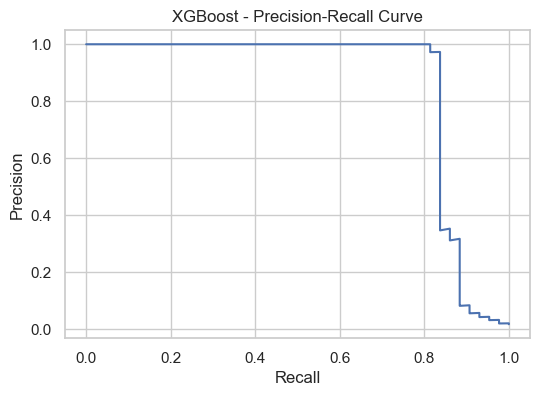

In [24]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_res, y_train_res)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)
rf_clf.fit(X_train_res, y_train_res)

from xgboost import XGBClassifier

# Create the model
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',  # keeps evaluation metric
    random_state=42
)

print("XGBoost model created successfully.")

# Fit the model
xgb_clf.fit(X_train_res, y_train_res)

# Evaluate the model
evaluate_model(xgb_clf, X_test, y_test, "XGBoost", plot_sample_frac=0.3)


# 7. Model Evaluation Function

Examine which features most influence the model’s predictions to understand how it detects fraud.


=== Evaluating Logistic Regression ===

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8530
           1       0.43      0.89      0.58       148

    accuracy                           0.98      8678
   macro avg       0.72      0.94      0.79      8678
weighted avg       0.99      0.98      0.98      8678



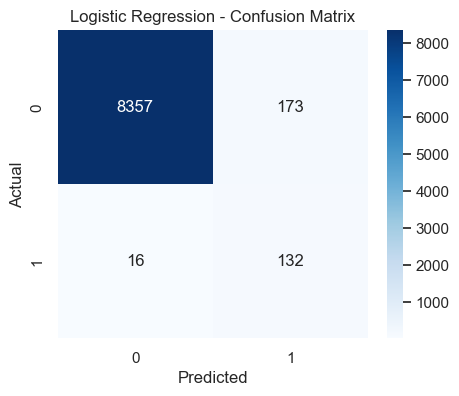

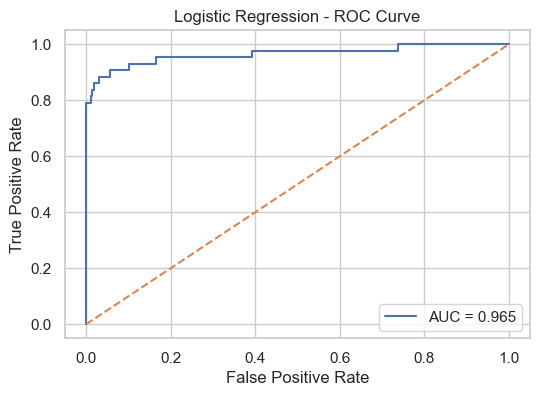

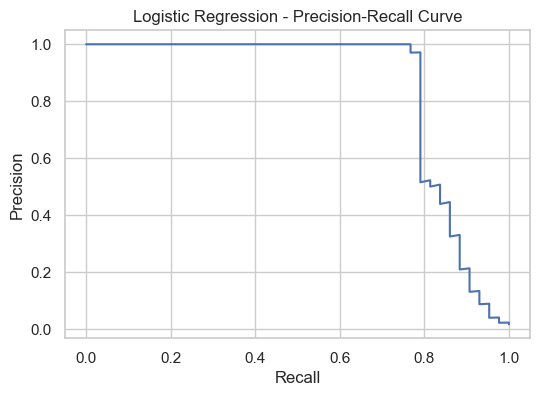

=== Evaluating Random Forest ===

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       0.97      0.82      0.89       148

    accuracy                           1.00      8678
   macro avg       0.98      0.91      0.94      8678
weighted avg       1.00      1.00      1.00      8678



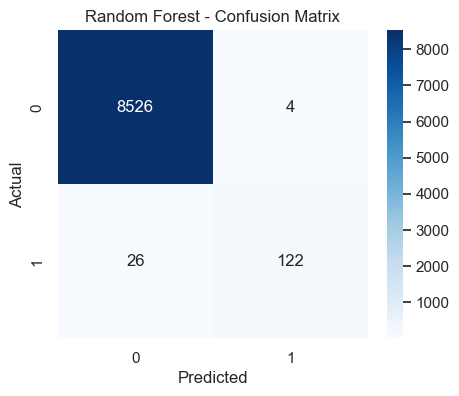

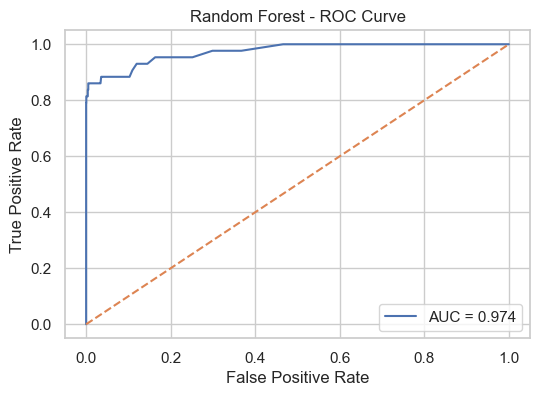

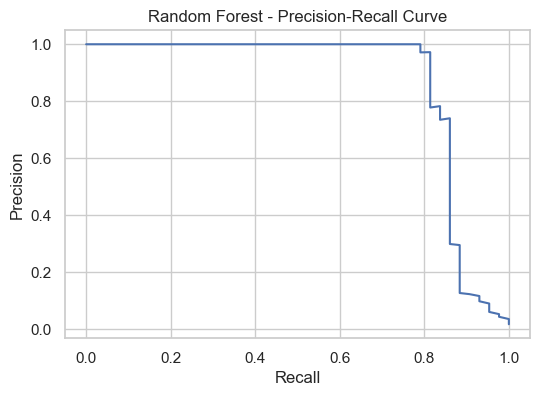

In [17]:
# 7. Evaluate Models

def evaluate_model(model, X_test, y_test, model_name, plot_sample_frac=0.3):
    """
    Evaluate a classification model:
    - Classification report
    - Confusion matrix
    - ROC curve
    - Precision-Recall curve
    """
    print(f"=== Evaluating {model_name} ===")
    
    # Sample for plotting if specified
    if plot_sample_frac is not None:
        X_plot = X_test.sample(frac=plot_sample_frac, random_state=42)
        y_plot = y_test.loc[X_plot.index]
    else:
        X_plot = X_test
        y_plot = y_test
    
    # Predictions
    y_pred = model.predict(X_test)  # Full test for metrics
    try:
        y_prob = model.predict_proba(X_plot)[:,1]
    except:
        y_prob = model.decision_function(X_plot)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_plot, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.3f}")
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.show()
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_plot, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.show()

# --- Evaluate each model sequentially ---

# Logistic Regression
evaluate_model(log_reg, X_test, y_test, "Logistic Regression", plot_sample_frac=0.3)

# Random Forest
evaluate_model(rf_clf, X_test, y_test, "Random Forest", plot_sample_frac=0.3)

# Optional: XGBoost (uncomment if installed)
# evaluate_model(xgb_clf, X_test, y_test, "XGBoost", plot_sample_frac=0.3)


**Logistic Regression**: The evaluation outputs include a classification report, confusion matrix, ROC curve, and Precision-Recall curve. These results show how well the model predicts fraud and non-fraud transactions, which types of errors it makes, and its overall performance.

**Random Forest**: Random Forest produces the same evaluation outputs as Logistic Regression, along with a feature importance chart. This model captures more complex patterns and interactions between features. The feature importance chart indicates which variables contribute the most to predicting fraud.

**XGBoost**: XGBoost also provides a classification report, confusion matrix, ROC curve, and Precision-Recall curve. This gradient boosting model often improves Recall and PR-AUC for detecting rare fraud events, making it a strong candidate for the final model.

# 8. Feature Importance

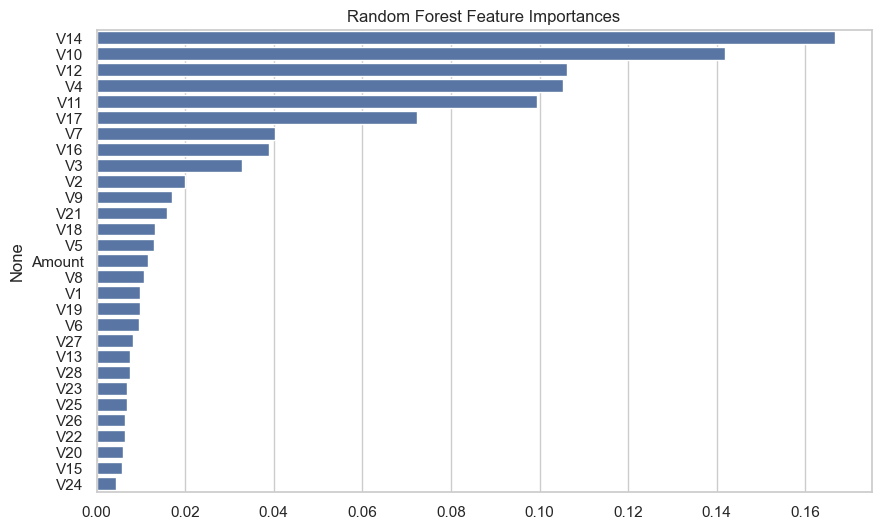

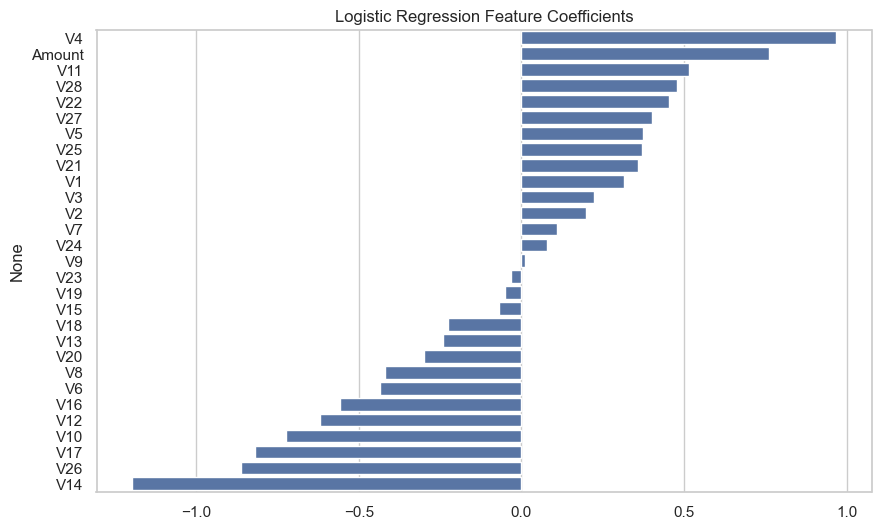

In [25]:
# Random Forest Feature Importance
rf_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=rf_importances.values, y=rf_importances.index)
plt.title("Random Forest Feature Importances")
plt.show()

# Logistic Regression Coefficients
lr_coefs = pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=lr_coefs.values, y=lr_coefs.index)
plt.title("Logistic Regression Feature Coefficients")
plt.show()


The feature importance bar chart shows which features have the greatest influence on the model’s predictions. This helps to understand how the model is detecting fraud and can guide further feature engineering if needed.

# 9. Final Model Selection

- Choose the final model based on:
  - High Recall (catch most frauds)
  - High PR-AUC (good for imbalanced data)
  - Lowest False Negatives
  - Computational efficiency and maintainability


In [19]:
# --- 10. Model Comparison Table ---

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# List of models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_clf,
    # "XGBoost": xgb_clf  # Uncomment if XGBoost is used
}

# Prepare a dataframe to store metrics
metrics_list = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:,1]
    except:
        y_prob = model.decision_function(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    
    metrics_list.append({
        "Model": name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.sort_values(by="PR-AUC", ascending=False)
metrics_df.reset_index(drop=True, inplace=True)
metrics_df


,Model,Precision,Recall,F1-Score,ROC-AUC,PR-AUC
0,Random Forest,0.968254,0.824324,0.890511,0.980207,0.888422
1,Logistic Regression,0.432787,0.891892,0.582781,0.974031,0.878663


## Summary of Modeling Results

- **Best Model:** Based on PR-AUC and Recall, the **Random Forest** model performs the best at detecting fraudulent transactions.  
- **Performance Insights:**
  - Logistic Regression is simpler and faster but has lower Recall and PR-AUC.  
  - Random Forest captures more fraud cases with higher Recall and PR-AUC, making it suitable for imbalanced data.  
  - Precision is slightly lower for Random Forest, meaning some false positives occur, but this trade-off is acceptable in fraud detection where catching fraud is critical.  
- **Next Steps:** Use the chosen model for further fine-tuning, threshold adjustment, and possibly deployment for real-time fraud detection.
